# Tutorial on Building Fair AI Models

## Presenter: Moninder Singh, IBM Research AI

## PyData New York, 2018

<a id="toc"></a>

## Table of Contents

[1. Summary](#summary)<br>
[2. Data Used](#data_used)<br>
[3. Learning model from MEPS dataset to predict utilization](#2015-data)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1. Load data & create splits for learning/validating/testing model](#2015-data-load)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.2. Learning model from original data](#original-2015-data)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.1. Metrics for original data](#original-2015-metrics)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.2. Learning Logistic Regression (LR) classifier from original data](#lr_orig)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.2.1. Training LR model from original data](#lr-train)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.2.2. Validating LR model from original data](#lr-validate)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.2.3. Testing LR model from original data](#lr-test)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.3 Bias Mitigation using pre-processing technique - Reweighing](#reweighing-2015)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.3.1. Transform data](#reweighing-2015-transform)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.3.2. Metrics for transformed data](#reweighing-2015-metrics)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.3.3. Learning Logistic Regression (LR) classifier from data transformed by reweighing](#lr_transf)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.3.3.1. Training LR model after reweighing](#lr-rw-train)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.3.3.2. Validating LR model after reweighing](#lr-rw-validate)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.3.3.3. Testing LR model after reweighing](#lr-rw-test)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.4. Bias Mitigation using in-processing technique - Prejudice Remover (PR)](#kamishima)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.4.1. Training PR model](#ks-train)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.4.2. Validating PR model](#ks-validate)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.4.3. Testing PR model](#ks-test)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.5. Bias Mitigation using pre-processing technique - Disparate Impact Remover (DIR)](#disparate-impact)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.5.1. Training DIR model](#di-train)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.5.2. Validating DIR model](#di-validate)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.5.3. Testing DIR model](#di-test)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.6. Summary of MEPS Model Learning Results](#summary-2015-learning)<br>

<a id="summary"></a>

## 1. Summary

[Back to TOC](#toc)<br>

The notebook demonstrates how a variety of fairness metrics and bias mitigation algorithms can used to detect and reduce bias when learning classifiers.

Additional information is available in the accompanying [presentation](https://github.com/monindersingh/pydata2018_fairAI_models_tutorial/blob/master/pydata_nyc_2018_building_fair_AI_models.pdf).

An open source Python toolkit, [AI Fairness 360 (AIF360)](https://github.com/IBM/AIF360), is used for this demonstration. This toolkit provides additional [examples](https://github.com/IBM/AIF360/tree/master/examples) of bias detection/mitigation as well as [guidance](http://aif360.mybluemix.net/resources#guidance) figuring out what metrics and algorithms will be most apropriate for a given problem.

Bias detection is demonstrated using several metrics, including disparate impact, average odds difference, statistical parity difference, equal opportunity difference, and Theil index.

Bias mitigation is explored via a variety of methods, including reweighing (pre-processing algorithm), prejudice remover (in-processing algorithm), and disparate impact remover (pre-processing technique).


<a id="use_case"></a>

<a id="data_used"></a>

## 2. Data used

[Back to TOC](#toc)<br>

#### Medical Expenditure Panel Survey (MEPS) data

The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181).

This file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). The For this demonstration, a dataset was constructed from panel 19, round 5.

The sensitive attribute is 'RACE' constructed as follows: 'Whites' (privileged class) defined by the features RACEV2X = 1 (White) and HISPANX = 2 (non Hispanic); 'Non-Whites' that includes everyone else. 

To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15, the number of office based visits;  OPTOTV15, the number of outpatient visits; ERTOT15, the number of ER visits;  IPNGTD15, the number of inpatient nights, and  + HHTOTD16, the number of home health visits.

The model classification task is to predict whether a person would have 'high' utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). Such people can be selected for case management and provided additional resources. High utilization respondents constituted around 17% of each dataset.



In [1]:
# Load all necessary packages
import sys
sys.path.append("../")
import numpy as np

#Datasets
from aif360.datasets.meps_dataset_panel19_fy2015 import MEPSDataset19
from aif360.datasets.meps_dataset_panel20_fy2015 import MEPSDataset20
from aif360.datasets.meps_dataset_panel21_fy2016 import MEPSDataset21

#Fairness Metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

#Scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score

#Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#Bias Mitigation Techniques
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.inprocessing.prejudice_remover import PrejudiceRemover
from aif360.algorithms.preprocessing import DisparateImpactRemover


from IPython.display import Markdown, display
%matplotlib inline

import matplotlib.pyplot as plt

#LIME
from aif360.datasets.lime_encoder import LimeEncoder
import lime
import lime.lime_tabular


<a id="2015-data"></a>

## 3. Learning models from MEPS data

[Back to TOC](#toc)<br>

<a id="2015-data-load"></a>

### 3.1. Load data & create splits for learning/validating/testing model

[Back to TOC](#toc)<br>

In [2]:
# Get the dataset and split into train, validate, and test

np.random.seed(1)


meps_orig = MEPSDataset19()
meps_orig_train, meps_orig_validate, meps_orig_test = \
                                    meps_orig.split([0.5,0.8], shuffle=True)

sens_attr = meps_orig_train.protected_attribute_names[0]


**Show MEPS dataset details**

In [3]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(meps_orig_train.features.shape)
display(Markdown("#### Validation Dataset shape"))
print(meps_orig_validate.features.shape)
display(Markdown("#### Test Dataset shape"))
print(meps_orig_test.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(meps_orig_train.favorable_label, meps_orig_train.unfavorable_label)
print(meps_orig_train.metadata['label_maps'][0][meps_orig_train.favorable_label],\
      meps_orig_train.metadata['label_maps'][0][meps_orig_train.unfavorable_label])
display(Markdown("#### Protected attribute names"))
print(meps_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(meps_orig_train.privileged_protected_attributes, 
      meps_orig_train.unprivileged_protected_attributes)
print(meps_orig_train.metadata['protected_attribute_maps'][0][meps_orig_train.privileged_protected_attributes[0][0]],
      meps_orig_train.metadata['protected_attribute_maps'][0][meps_orig_train.unprivileged_protected_attributes[0][0]])


display(Markdown("#### Dataset feature names"))
print(meps_orig_train.feature_names)

#### Training Dataset shape

(7915, 138)


#### Validation Dataset shape

(4749, 138)


#### Test Dataset shape

(3166, 138)


#### Favorable and unfavorable labels

1.0 0.0
>= 10 Visits < 10 Visits


#### Protected attribute names

['RACE']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]
White Non-White


#### Dataset feature names

['MCS42', 'AGE', 'PCS42', 'RACE', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RTHLTH=4', 'RTHLTH=5', 'MNHLTH=-1', 'MNHLTH=1', 'MNHLTH=2', 'MNHLTH=3', 'MNHLTH=4', 'MNHLTH=5', 'HIBPDX=-1', 'HIBPDX=1', 'HIBPDX=2', 'CHDDX=-1', 'CHDDX=1', 'CHDDX=2', 'ANGIDX=-1', 'ANGIDX=1', 'ANGIDX=2', 'MIDX=-1', 'MIDX=1', 'MIDX=2', 'OHRTDX=-1', 'OHRTDX=1', 'OHRTDX=2', 'STRKDX=-1', 'STRKDX=1', 'STRKDX=2', 'EMPHDX=-1', 'EMPHDX=1', 'EMPHDX=2', 'CHBRON=-1', 'CHBRON=1', 'CHBRON=2', 'CHOLDX=-1', 'CHOLDX=1', 'CHOLDX=2', 'CANCERDX=-1', 'CANCERDX=1', 'CANCERDX=2', 'DIABDX=-1', 'DIABDX=1', 'DIABDX=2', 'JTPAIN=-1', 'JTPAIN=1', 'JTPAIN=2', 'ARTHDX=-1', 'ARTHDX=1', 'ARTHDX=2', 'ARTHTYPE=-1'

<a id="original-2015-data"></a>

### 3.2. Learning model from original data

[Back to TOC](#toc)<br>

<a id="original-2015-metrics"></a>

#### 3.2.1. Metrics for original data

In [4]:
# Metric for the original dataset
sens_idx = meps_orig_train.protected_attribute_names.index(sens_attr)
privileged_groups =  [{sens_attr:meps_orig_train.privileged_protected_attributes[sens_idx][0]}]
unprivileged_groups = [{sens_attr:meps_orig_train.unprivileged_protected_attributes[sens_idx][0]}]
metric_meps_orig_train = BinaryLabelDatasetMetric(meps_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % \
                                                  metric_meps_orig_train.mean_difference())
print("Disparate impact (ratio of unprivileged favorable mean to privileged favorable mean) = %f" % \
                                                  metric_meps_orig_train.disparate_impact())


#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.136594
Disparate impact (ratio of unprivileged favorable mean to privileged favorable mean) = 0.482305


<a id="lr_orig"></a>

#### 3.2.2. Learning Logistic Regression (LR) classifier from original data

<a id="lr-train"></a>

#### 3.2.2.1. Training LR model from original data

In [5]:
#Train model on given dataset

dataset = meps_orig_train  # data to train on

scale = StandardScaler().fit(dataset.features)   # remember the scale

model = LogisticRegression()       # model to learn

X_train = scale.transform(dataset.features)      #apply the scale
y_train = dataset.labels.ravel()


model.fit(X_train, y_train,
        sample_weight=dataset.instance_weights)
y_train_pred = model.predict(X_train)

#save model
meps_orig_lr = model
meps_orig_lr_scale = scale

C:\ProgramData\Anaconda3\envs\aif360\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<a id="lr-validate"></a>

#### 3.2.2.2. Validating LR model from original data

In [6]:
#Validate model on given dataset and find threshold for best balanced accuracy
import numpy as np
from tqdm import tqdm
thresh_arr = np.linspace(0.01, 0.5, 50)

scale = meps_orig_lr_scale

model = meps_orig_lr                  #model to validate
dataset = meps_orig_validate        #data to validate on

X_validate = scale.transform(dataset.features)   #apply the same scale as applied to the training data
y_validate = dataset.labels.ravel()
y_validate_pred_prob = model.predict_proba(X_validate)


bal_acc_arr = []
disp_imp_arr = []
avg_odds_diff_arr = []
stat_par_diff = []
eq_opp_diff = []
theil_ind = []
    
for thresh in tqdm(thresh_arr):
    y_validate_pred = (y_validate_pred_prob[:,1] > thresh).astype(np.double)

    dataset_pred = dataset.copy()
    dataset_pred.labels = y_validate_pred

    classified_metric = ClassificationMetric(dataset, 
                                                 dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    
    bal_acc = 0.5*(classified_metric.true_positive_rate() + classified_metric.true_negative_rate())
    
    acc = accuracy_score(y_true=dataset.labels,
                            y_pred=dataset_pred.labels)
    bal_acc_arr.append(bal_acc)
    avg_odds_diff_arr.append(classified_metric.average_odds_difference())
    disp_imp_arr.append(metric_pred.disparate_impact())
    stat_par_diff.append(classified_metric.statistical_parity_difference())
    eq_opp_diff.append(classified_metric.equal_opportunity_difference())
    theil_ind.append(classified_metric.theil_index())

    
thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
disp_imp_at_best_bal_acc = np.abs(1.0-np.array(disp_imp_arr))[thresh_arr_best_ind]

avg_odds_diff_at_best_bal_acc = avg_odds_diff_arr[thresh_arr_best_ind]

stat_par_diff_at_best_bal_acc = stat_par_diff[thresh_arr_best_ind]
eq_opp_diff_at_best_bal_acc = eq_opp_diff[thresh_arr_best_ind]
theil_ind_at_best_bal_acc = theil_ind[thresh_arr_best_ind]

100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 167.17it/s]


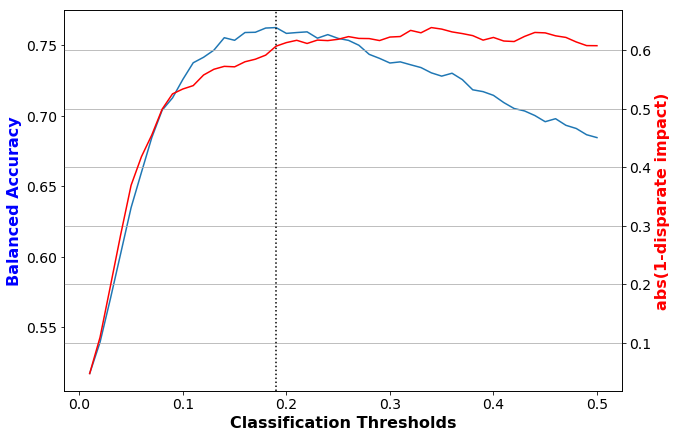

In [7]:
#Plot balanced accuracy, abs(1-disparate impact)

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(thresh_arr, bal_acc_arr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(thresh_arr, np.abs(1.0-np.array(disp_imp_arr)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')

ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)


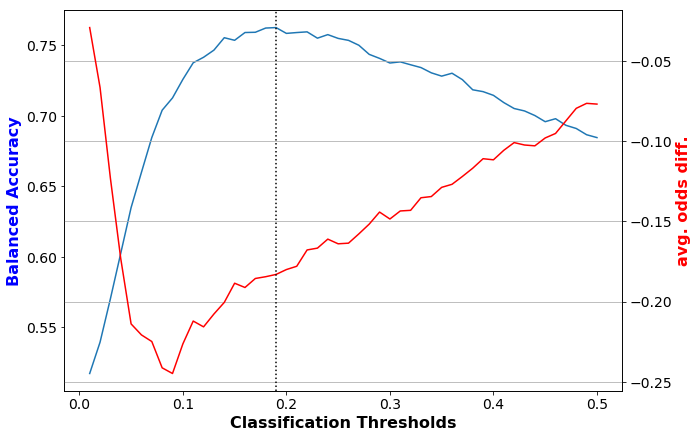

In [8]:
#Plot average odds difference
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(thresh_arr, bal_acc_arr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(thresh_arr, avg_odds_diff_arr, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')

ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [9]:
lr_thresh_arr_orig_meps_best = thresh_arr_best
print("Threshold corresponding to Best balanced accuracy: %6.4f" % lr_thresh_arr_orig_meps_best)
lr_best_bal_acc_arr_orig_meps = best_bal_acc
print("Best balanced accuracy: %6.4f" % lr_best_bal_acc_arr_orig_meps)
lr_disp_imp_at_best_bal_acc_orig_meps = disp_imp_at_best_bal_acc
print("Corresponding abs(1-disparate impact) value: %6.4f" % lr_disp_imp_at_best_bal_acc_orig_meps)
lr_avg_odds_diff_at_best_bal_acc_orig_meps = avg_odds_diff_at_best_bal_acc
print("Corresponding average odds difference value: %6.4f" % lr_avg_odds_diff_at_best_bal_acc_orig_meps)
lr_stat_par_diff_at_best_bal_acc_orig_meps = stat_par_diff_at_best_bal_acc
print("Corresponding statistical parity difference value: %6.4f" % lr_stat_par_diff_at_best_bal_acc_orig_meps)
lr_eq_opp_diff_at_best_bal_acc_orig_meps = eq_opp_diff_at_best_bal_acc
print("Corresponding equal opportunity difference value: %6.4f" % lr_eq_opp_diff_at_best_bal_acc_orig_meps)
lr_theil_ind_at_best_bal_acc_orig_meps = theil_ind_at_best_bal_acc
print("Corresponding Theil index value: %6.4f" % lr_theil_ind_at_best_bal_acc_orig_meps)

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7627
Corresponding abs(1-disparate impact) value: 0.6066
Corresponding average odds difference value: -0.1831
Corresponding statistical parity difference value: -0.2643
Corresponding equal opportunity difference value: -0.1608
Corresponding Theil index value: 0.0936


<a id="lr-test"></a>

#### 3.2.2.3. Testing LR model from original data

In [10]:
#Evaluate performance of a given model with a given threshold on a given dataset

scale = meps_orig_lr_scale

dataset = meps_orig_test   #apply model to this data
model = meps_orig_lr               #this is the model applied

thresh_arr = lr_thresh_arr_orig_meps_best  


X_data = scale.transform(dataset.features)
y_data = dataset.labels.ravel()
y_data_pred_prob = model.predict_proba(X_data)  

    
y_pred = (y_data_pred_prob[:,1] > thresh_arr).astype(np.double)

dataset_pred = dataset.copy()
dataset_pred.labels = y_pred

classified_metric = ClassificationMetric(dataset, 
                                        dataset_pred,
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
    
TPR = classified_metric.true_positive_rate()
TNR = classified_metric.true_negative_rate()
bal_acc = 0.5*(TPR+TNR)
    
acc = accuracy_score(y_true=dataset.labels,
                    y_pred=dataset_pred.labels)

#get results
best_bal_acc = bal_acc
disp_imp_at_best_bal_acc = np.abs(1.0-metric_pred.disparate_impact())

avg_odds_diff_at_best_bal_acc = classified_metric.average_odds_difference()

stat_par_diff_at_best_bal_acc = classified_metric.statistical_parity_difference()
eq_opp_diff_at_best_bal_acc = classified_metric.equal_opportunity_difference()
theil_ind_at_best_bal_acc = classified_metric.theil_index()

In [11]:
lr_thresh_arr_orig_meps_best_test = thresh_arr_best
print("Threshold corresponding to Best balanced accuracy: %6.4f" % lr_thresh_arr_orig_meps_best_test)
lr_best_bal_acc_arr_orig_meps_best_test = best_bal_acc
print("Best balanced accuracy: %6.4f" % lr_best_bal_acc_arr_orig_meps_best_test)
lr_disp_imp_at_best_bal_acc_orig_meps_best_test = disp_imp_at_best_bal_acc
print("Corresponding abs(1-disparate impact) value: %6.4f" % lr_disp_imp_at_best_bal_acc_orig_meps_best_test)
lr_avg_odds_diff_at_best_bal_acc_orig_meps_best_test = avg_odds_diff_at_best_bal_acc
print("Corresponding average odds difference value: %6.4f" % lr_avg_odds_diff_at_best_bal_acc_orig_meps_best_test)

lr_stat_par_diff_at_best_bal_acc_orig_meps_best_test = stat_par_diff_at_best_bal_acc
print("Corresponding statistical parity difference value: %6.4f" % lr_stat_par_diff_at_best_bal_acc_orig_meps_best_test)
lr_eq_opp_diff_at_best_bal_acc_orig_meps_best_test = eq_opp_diff_at_best_bal_acc
print("Corresponding equal opportunity difference value: %6.4f" % lr_eq_opp_diff_at_best_bal_acc_orig_meps_best_test)
lr_theil_ind_at_best_bal_acc_orig_meps_best_test = theil_ind_at_best_bal_acc
print("Corresponding Theil index value: %6.4f" % lr_theil_ind_at_best_bal_acc_orig_meps_best_test)

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7759
Corresponding abs(1-disparate impact) value: 0.5738
Corresponding average odds difference value: -0.2057
Corresponding statistical parity difference value: -0.2612
Corresponding equal opportunity difference value: -0.2228
Corresponding Theil index value: 0.0921


For all the fairness metrics displayed above, the value should be close to '0' for fairness.

abs(1-disparate impact) is typically desired to be < 0.2 for classifier predictions to be fair.

However, for a logistic regression classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

Similarly, average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.

For a logistic regression classifier trained with original training data, at the best classification rate, this is still high. This still implies unfairness.

<a id="rf_orig"></a>

<a id="rf-train"></a>

<a id="reweighing-2015"></a>

### 3.3. Bias Mitigation using pre-processing technique - Reweighing

[Back to TOC](#toc)<br>

<a id="reweighing-2015-transform"></a>

#### 3.3.1. Transform data

In [12]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(meps_orig_train)
meps_trans_train = RW.transform(meps_orig_train)

<a id="reweighing-2015-metrics"></a>

#### 3.3.2. Metrics for transformed data

In [13]:
metric_meps_transf_train = BinaryLabelDatasetMetric(meps_trans_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % \
                                                  metric_meps_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between privileged and unprivileged groups = 0.000000


<a id="lr_transf"></a>

#### 3.3.3. Learning Logistic Regression (LR) classifier from data transformed by reweighing

<a id="lr-rw-train"></a>

#### 3.3.3.1. Training LR model after reweighing

In [14]:
#Train model on given dataset

dataset = meps_trans_train  # data to train on

scale = StandardScaler().fit(dataset.features)   # remember the scale

model = LogisticRegression()       # model to learn

X_train = scale.transform(dataset.features)      #apply the scale

y_train = dataset.labels.ravel()


model.fit(X_train, y_train,
        sample_weight=dataset.instance_weights)
y_train_pred = model.predict(X_train)

#save model
meps_trans_lr = model
meps_trans_lr_scale = scale

C:\ProgramData\Anaconda3\envs\aif360\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<a id="lr-rw-validate"></a>

#### 3.3.3.2. Validating  LR model after reweighing

In [15]:
#validate model on given dataset and find threshold for best balanced accuracy
import numpy as np
from tqdm import tqdm
thresh_arr = np.linspace(0.01, 0.5, 50)

scale = meps_trans_lr_scale

model = meps_trans_lr                  #model to validate
dataset = meps_orig_validate        #data to validate on

X_validate = scale.transform(dataset.features)   #apply the same scale as applied to the training data
y_validate = dataset.labels.ravel()
y_validate_pred_prob = model.predict_proba(X_validate)


bal_acc_arr = []
disp_imp_arr = []
avg_odds_diff_arr = []
stat_par_diff = []
eq_opp_diff = []
theil_ind = []
    
for thresh in tqdm(thresh_arr):
    y_validate_pred = (y_validate_pred_prob[:,1] > thresh).astype(np.double)

    dataset_pred = dataset.copy()
    dataset_pred.labels = y_validate_pred

    classified_metric = ClassificationMetric(dataset, 
                                                 dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    
    bal_acc = 0.5*(classified_metric.true_positive_rate() + classified_metric.true_negative_rate())
    
    acc = accuracy_score(y_true=dataset.labels,
                            y_pred=dataset_pred.labels)
    bal_acc_arr.append(bal_acc)
    avg_odds_diff_arr.append(classified_metric.average_odds_difference())
    disp_imp_arr.append(metric_pred.disparate_impact())
    stat_par_diff.append(classified_metric.statistical_parity_difference())
    eq_opp_diff.append(classified_metric.equal_opportunity_difference())
    theil_ind.append(classified_metric.theil_index())

    
thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
disp_imp_at_best_bal_acc = np.abs(1.0-np.array(disp_imp_arr))[thresh_arr_best_ind]

avg_odds_diff_at_best_bal_acc = avg_odds_diff_arr[thresh_arr_best_ind]

stat_par_diff_at_best_bal_acc = stat_par_diff[thresh_arr_best_ind]
eq_opp_diff_at_best_bal_acc = eq_opp_diff[thresh_arr_best_ind]
theil_ind_at_best_bal_acc = theil_ind[thresh_arr_best_ind]

100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 151.65it/s]


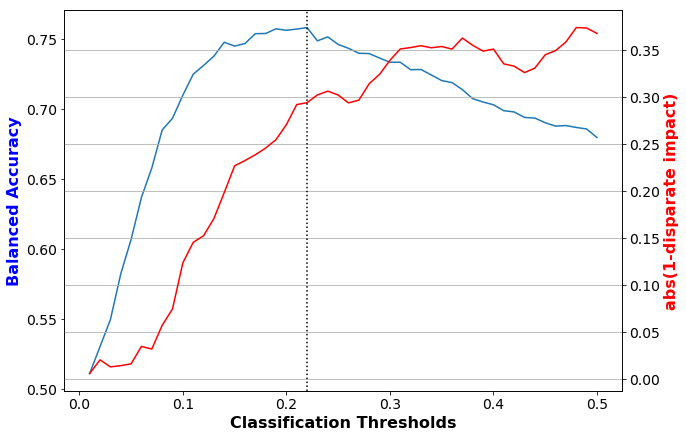

In [16]:
#Plot balanced accuracy, abs(1-disparate impact)

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(thresh_arr, bal_acc_arr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(thresh_arr, np.abs(1.0-np.array(disp_imp_arr)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')

ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)


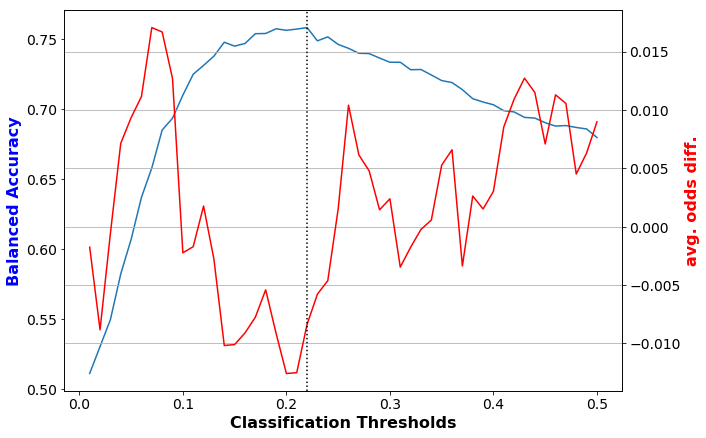

In [17]:
#Plot average odds difference
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(thresh_arr, bal_acc_arr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(thresh_arr, avg_odds_diff_arr, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')

ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [18]:
lr_thresh_arr_transf_meps_best = thresh_arr_best
print("Threshold corresponding to Best balanced accuracy: %6.4f" % lr_thresh_arr_transf_meps_best)
lr_best_bal_acc_arr_transf_meps = best_bal_acc
print("Best balanced accuracy: %6.4f" % lr_best_bal_acc_arr_transf_meps)
lr_disp_imp_at_best_bal_acc_transf_meps = disp_imp_at_best_bal_acc
print("Corresponding abs(1-disparate impact) value: %6.4f" % lr_disp_imp_at_best_bal_acc_transf_meps)
lr_avg_odds_diff_at_best_bal_acc_transf_meps = avg_odds_diff_at_best_bal_acc
print("Corresponding average odds difference value: %6.4f" % lr_avg_odds_diff_at_best_bal_acc_transf_meps)

lr_stat_par_diff_at_best_bal_acc_transf_meps = stat_par_diff_at_best_bal_acc
print("Corresponding statistical parity difference value: %6.4f" % lr_stat_par_diff_at_best_bal_acc_transf_meps)
lr_eq_opp_diff_at_best_bal_acc_transf_meps = eq_opp_diff_at_best_bal_acc
print("Corresponding equal opportunity difference value: %6.4f" % lr_eq_opp_diff_at_best_bal_acc_transf_meps)
lr_theil_ind_at_best_bal_acc_transf_meps = theil_ind_at_best_bal_acc
print("Corresponding Theil index value: %6.4f" % lr_theil_ind_at_best_bal_acc_transf_meps)

Threshold corresponding to Best balanced accuracy: 0.2200
Best balanced accuracy: 0.7581
Corresponding abs(1-disparate impact) value: 0.2939
Corresponding average odds difference value: -0.0084
Corresponding statistical parity difference value: -0.0992
Corresponding equal opportunity difference value: 0.0242
Corresponding Theil index value: 0.0938


<a id="lr-rw-test"></a>

#### 3.3.3.3. Testing  LR model after reweighing

In [19]:
#Evaluate performance of a given model with a given threshold on a given dataset

scale = meps_trans_lr_scale

dataset = meps_orig_test   #apply model to this data
model = meps_trans_lr               #this is the model applied
                                   #lr_transf_panel19 is LR model learned from Panel 19
                                   #transformed data
thresh_arr = lr_thresh_arr_transf_meps_best  # lr_thresh_arr_transf_panel19_best wass threshold for LR
                                            # model with highest balanced accuracy


X_data = scale.transform(dataset.features)
y_data = dataset.labels.ravel()
y_data_pred_prob = model.predict_proba(X_data)  

    
y_pred = (y_data_pred_prob[:,1] > thresh_arr).astype(np.double)

dataset_pred = dataset.copy()
dataset_pred.labels = y_pred

classified_metric = ClassificationMetric(dataset, 
                                        dataset_pred,
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
    
TPR = classified_metric.true_positive_rate()
TNR = classified_metric.true_negative_rate()
bal_acc = 0.5*(TPR+TNR)
    
acc = accuracy_score(y_true=dataset.labels,
                    y_pred=dataset_pred.labels)

#get results
best_bal_acc = bal_acc
disp_imp_at_best_bal_acc = np.abs(1.0-metric_pred.disparate_impact())

avg_odds_diff_at_best_bal_acc = classified_metric.average_odds_difference()

stat_par_diff_at_best_bal_acc = classified_metric.statistical_parity_difference()
eq_opp_diff_at_best_bal_acc = classified_metric.equal_opportunity_difference()
theil_ind_at_best_bal_acc = classified_metric.theil_index()

In [20]:
lr_thresh_arr_transf_meps_best_test = thresh_arr_best
print("Threshold corresponding to Best balanced accuracy: %6.4f" % lr_thresh_arr_transf_meps_best_test)
lr_best_bal_acc_arr_transf_meps_best_test = best_bal_acc
print("Best balanced accuracy: %6.4f" % lr_best_bal_acc_arr_transf_meps_best_test)
lr_disp_imp_at_best_bal_acc_transf_meps_best_test = disp_imp_at_best_bal_acc
print("Corresponding abs(1-disparate impact) value: %6.4f" % lr_disp_imp_at_best_bal_acc_transf_meps_best_test)
lr_avg_odds_diff_at_best_bal_acc_transf_meps_best_test = avg_odds_diff_at_best_bal_acc
print("Corresponding average odds difference value: %6.4f" % lr_avg_odds_diff_at_best_bal_acc_transf_meps_best_test)

lr_stat_par_diff_at_best_bal_acc_transf_meps_best_test = stat_par_diff_at_best_bal_acc
print("Corresponding statistical parity difference value: %6.4f" % lr_stat_par_diff_at_best_bal_acc_transf_meps_best_test)
lr_eq_opp_diff_at_best_bal_acc_transf_meps_best_test = eq_opp_diff_at_best_bal_acc
print("Corresponding equal opportunity difference value: %6.4f" % lr_eq_opp_diff_at_best_bal_acc_transf_meps_best_test)
lr_theil_ind_at_best_bal_acc_transf_meps_best_test = theil_ind_at_best_bal_acc
print("Corresponding Theil index value: %6.4f" % lr_theil_ind_at_best_bal_acc_transf_meps_best_test)

Threshold corresponding to Best balanced accuracy: 0.2200
Best balanced accuracy: 0.7539
Corresponding abs(1-disparate impact) value: 0.2482
Corresponding average odds difference value: -0.0151
Corresponding statistical parity difference value: -0.0872
Corresponding equal opportunity difference value: -0.0035
Corresponding Theil index value: 0.0966


The fairness metrics for the logistic regression model learnt after reweighing are fairly improved, and thus the model is much more fair relative to the logistic regression model learnt from the original data.

<a id="rf_transf"></a>

<a id="kamishima"></a>

### 3.4. Bias Mitigation using in-processing technique - Prejudice Remover (PR)

[Back to TOC](#toc)<br>

<a id="ks-train"></a>

#### 3.4.1. Training PR model

In [21]:
model = PrejudiceRemover(sensitive_attr=sens_attr, eta = 25.0)

In [22]:
#Train model on given dataset

dataset = meps_orig_train  # data to train on

tr_dataset = dataset.copy(deepcopy=True)
scale = StandardScaler().fit(tr_dataset.features)   # remember the scale

tr_dataset.features = scale.transform(tr_dataset.features)
        


model.fit(tr_dataset)

#save model
meps_orig_pr = model
meps_orig_pr_scale = scale

<a id="ks-validate"></a>

#### 3.4.2. Validating PR model

In [23]:
#validate model on given dataset and find threshold for best balanced accuracy
import numpy as np
from tqdm import tqdm
thresh_arr = np.linspace(0.01, 0.5, 50)

dataset = meps_orig_validate        #data to validate on

model = meps_orig_pr
scale = meps_orig_pr_scale

te_dataset= dataset.copy(deepcopy=True)
te_dataset.features = scale.transform(te_dataset.features)
pred_dataset = model.predict(te_dataset)

y_validate_pred_prob = pred_dataset.scores


bal_acc_arr = []
disp_imp_arr = []
avg_odds_diff_arr = []
stat_par_diff = []
eq_opp_diff = []
theil_ind = []
    
for thresh in tqdm(thresh_arr):
    y_validate_pred = (y_validate_pred_prob[:,1] > thresh).astype(np.double)

    dataset_pred = dataset.copy()
    dataset_pred.labels = y_validate_pred

    classified_metric = ClassificationMetric(dataset, 
                                                 dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    
    bal_acc = 0.5*(classified_metric.true_positive_rate() + classified_metric.true_negative_rate())
    
    acc = accuracy_score(y_true=dataset.labels,
                            y_pred=dataset_pred.labels)
    bal_acc_arr.append(bal_acc)
    avg_odds_diff_arr.append(classified_metric.average_odds_difference())
    disp_imp_arr.append(metric_pred.disparate_impact())
    stat_par_diff.append(classified_metric.statistical_parity_difference())
    eq_opp_diff.append(classified_metric.equal_opportunity_difference())
    theil_ind.append(classified_metric.theil_index())

    
thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
disp_imp_at_best_bal_acc = np.abs(1.0-np.array(disp_imp_arr))[thresh_arr_best_ind]

avg_odds_diff_at_best_bal_acc = avg_odds_diff_arr[thresh_arr_best_ind]

stat_par_diff_at_best_bal_acc = stat_par_diff[thresh_arr_best_ind]
eq_opp_diff_at_best_bal_acc = eq_opp_diff[thresh_arr_best_ind]
theil_ind_at_best_bal_acc = theil_ind[thresh_arr_best_ind]

100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 196.31it/s]


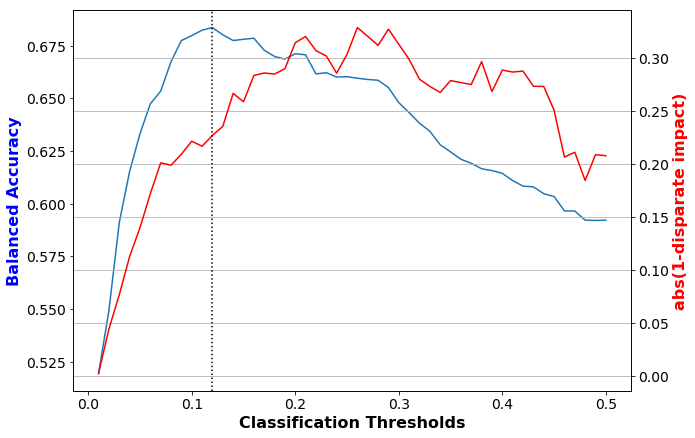

In [24]:
#Plot balanced accuracy, abs(1-disparate impact)

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(thresh_arr, bal_acc_arr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(thresh_arr, np.abs(1.0-np.array(disp_imp_arr)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')

ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)


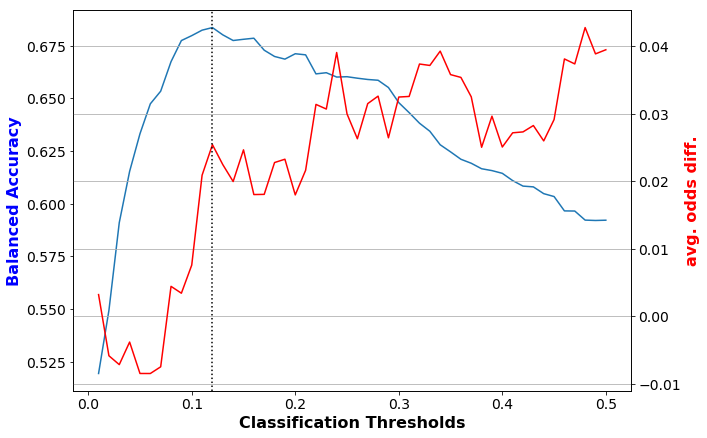

In [25]:
#Plot average odds difference
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(thresh_arr, bal_acc_arr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(thresh_arr, avg_odds_diff_arr, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')

ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [26]:
pr_thresh_arr_orig_meps_best = thresh_arr_best
print("Threshold corresponding to Best balanced accuracy: %6.4f" % pr_thresh_arr_orig_meps_best)
pr_best_bal_acc_arr_orig_meps = best_bal_acc
print("Best balanced accuracy: %6.4f" % pr_best_bal_acc_arr_orig_meps)
pr_disp_imp_at_best_bal_acc_orig_meps = disp_imp_at_best_bal_acc
print("Corresponding abs(1-disparate impact) value: %6.4f" % pr_disp_imp_at_best_bal_acc_orig_meps)
pr_avg_odds_diff_at_best_bal_acc_orig_meps = avg_odds_diff_at_best_bal_acc
print("Corresponding average odds difference value: %6.4f" % pr_avg_odds_diff_at_best_bal_acc_orig_meps)

pr_stat_par_diff_at_best_bal_acc_orig_meps = stat_par_diff_at_best_bal_acc
print("Corresponding statistical parity difference value: %6.4f" % pr_stat_par_diff_at_best_bal_acc_orig_meps)
pr_eq_opp_diff_at_best_bal_acc_orig_meps = eq_opp_diff_at_best_bal_acc
print("Corresponding equal opportunity difference value: %6.4f" % pr_eq_opp_diff_at_best_bal_acc_orig_meps)
pr_theil_ind_at_best_bal_acc_orig_meps = theil_ind_at_best_bal_acc
print("Corresponding Theil index value: %6.4f" % pr_theil_ind_at_best_bal_acc_orig_meps)

Threshold corresponding to Best balanced accuracy: 0.1200
Best balanced accuracy: 0.6836
Corresponding abs(1-disparate impact) value: 0.2268
Corresponding average odds difference value: 0.0254
Corresponding statistical parity difference value: -0.0830
Corresponding equal opportunity difference value: 0.1172
Corresponding Theil index value: 0.1119


<a id="ks-test"></a>

#### 3.4.3. Testing PR model

In [27]:
#Test model on given dataset and find threshold for best balanced accuracy
import numpy as np
from tqdm import tqdm
thresh_arr = np.linspace(0.01, 0.75, 75)

dataset = meps_orig_test        #data to test on
scale = meps_orig_pr_scale
model = meps_orig_pr

thresh_arr = pr_thresh_arr_orig_meps_best

te_dataset= dataset.copy(deepcopy=True)
te_dataset.features = scale.transform(te_dataset.features)
pred_dataset = model.predict(te_dataset)

y_data_pred_prob = pred_dataset.scores


y_data_pred = (y_data_pred_prob[:,1] > thresh_arr).astype(np.double)

dataset_pred = dataset.copy()
dataset_pred.labels = y_data_pred

classified_metric = ClassificationMetric(dataset, 
                                            dataset_pred,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
    
bal_acc = 0.5*(classified_metric.true_positive_rate() + classified_metric.true_negative_rate())
    
acc = accuracy_score(y_true=dataset.labels,
                    y_pred=dataset_pred.labels)

best_bal_acc = bal_acc
disp_imp_at_best_bal_acc = np.abs(1.0-metric_pred.disparate_impact())

avg_odds_diff_at_best_bal_acc = classified_metric.average_odds_difference()

stat_par_diff_at_best_bal_acc = classified_metric.statistical_parity_difference()
eq_opp_diff_at_best_bal_acc = classified_metric.equal_opportunity_difference()
theil_ind_at_best_bal_acc = classified_metric.theil_index()

In [28]:
pr_thresh_arr_orig_meps_best_test = thresh_arr_best
print("Threshold corresponding to Best balanced accuracy: %6.4f" % pr_thresh_arr_orig_meps_best_test)
pr_best_bal_acc_arr_orig_meps_best_test = best_bal_acc
print("Best balanced accuracy: %6.4f" % pr_best_bal_acc_arr_orig_meps_best_test)
pr_disp_imp_at_best_bal_acc_orig_meps_best_test = disp_imp_at_best_bal_acc
print("Corresponding abs(1-disparate impact) value: %6.4f" % pr_disp_imp_at_best_bal_acc_orig_meps_best_test)
pr_avg_odds_diff_at_best_bal_acc_orig_meps_best_test = avg_odds_diff_at_best_bal_acc
print("Corresponding average odds difference value: %6.4f" % pr_avg_odds_diff_at_best_bal_acc_orig_meps_best_test)

pr_stat_par_diff_at_best_bal_acc_orig_meps_best_test = stat_par_diff_at_best_bal_acc
print("Corresponding statistical parity difference value: %6.4f" % pr_stat_par_diff_at_best_bal_acc_orig_meps_best_test)
pr_eq_opp_diff_at_best_bal_acc_orig_meps_best_test = eq_opp_diff_at_best_bal_acc
print("Corresponding equal opportunity difference value: %6.4f" % pr_eq_opp_diff_at_best_bal_acc_orig_meps_best_test)
pr_theil_ind_at_best_bal_acc_orig_meps_best_test = theil_ind_at_best_bal_acc
print("Corresponding Theil index value: %6.4f" % pr_theil_ind_at_best_bal_acc_orig_meps_best_test)

Threshold corresponding to Best balanced accuracy: 0.1200
Best balanced accuracy: 0.6880
Corresponding abs(1-disparate impact) value: 0.1588
Corresponding average odds difference value: 0.0523
Corresponding statistical parity difference value: -0.0566
Corresponding equal opportunity difference value: 0.1479
Corresponding Theil index value: 0.1108


As in the case of re-weighing, prejudice remover has resulted in a fair model. However, it hs come at an expense of relative lower balanced accuracy.

<a id="disparate-impact"></a>

### 3.5. Bias mitigation using pre-processing technique - Disparate Impact (DIR) Remover

[Back to TOC](#toc)<br>

<a id="di-train"></a>

#### 3.5.1. Training DIR model

In [29]:
#Train model on given dataset

dataset = meps_orig_train  # data to train on

tr_dataset = dataset.copy(deepcopy=True)
scale = MinMaxScaler().fit(tr_dataset.features)   # remember the scale

tr_dataset.features = scale.transform(tr_dataset.features)
index = tr_dataset.feature_names.index(sens_attr)        

di = DisparateImpactRemover(repair_level=1.0)
train_repd = di.fit_transform(tr_dataset) #repair training dataset

X_tr = np.delete(train_repd.features, index, axis=1)
    

y_tr = train_repd.labels.ravel()
    
model = LogisticRegression(random_state = 1, class_weight='balanced')
model.fit(X_tr, y_tr)

meps_orig_dir_scale = scale
meps_orig_dir = model

C:\ProgramData\Anaconda3\envs\aif360\lib\site-packages\BlackBoxAuditing\audit_reading.py:7: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg') # Set the back-end
C:\ProgramData\Anaconda3\envs\aif360\lib\site-packages\BlackBoxAuditing\consistency_graph.py:5: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg') # Set the back-end
C:\ProgramData\Anaconda3\envs\aif360\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<a id="di-validate"></a>

#### 3.5.2. Validating DIR model

In [30]:
#validate model on given dataset and find threshold for best balanced accuracy
import numpy as np
from tqdm import tqdm

scale = meps_orig_dir_scale
model = meps_orig_dir

thresh_arr = np.linspace(0.01, 0.75, 75)

dataset = meps_orig_validate        #data to validate on

te_dataset= dataset.copy(deepcopy=True)
te_dataset.features = scale.transform(te_dataset.features)

validate_repd = di.fit_transform(te_dataset)  #repair validate dataset

X_te = np.delete(validate_repd.features, index, axis=1)
    

y_te_pred_prob = model.predict_proba(X_te)


bal_acc_arr = []
disp_imp_arr = []
avg_odds_diff_arr = []
stat_par_diff = []
eq_opp_diff = []
theil_ind = []
    
for thresh in tqdm(thresh_arr):
    y_te_pred = (y_te_pred_prob[:,1] > thresh).astype(np.double)

    validate_repd_pred = validate_repd.copy()
    validate_repd_pred.labels = y_te_pred

    classified_metric = ClassificationMetric(validate_repd, 
                                                 validate_repd_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metric_pred = BinaryLabelDatasetMetric(validate_repd_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    
    bal_acc = 0.5*(classified_metric.true_positive_rate() + classified_metric.true_negative_rate())
    
    acc = accuracy_score(y_true=validate_repd.labels,
                            y_pred=validate_repd_pred.labels)
    bal_acc_arr.append(bal_acc)
    avg_odds_diff_arr.append(classified_metric.average_odds_difference())
    disp_imp_arr.append(metric_pred.disparate_impact())
    stat_par_diff.append(classified_metric.statistical_parity_difference())
    eq_opp_diff.append(classified_metric.equal_opportunity_difference())
    theil_ind.append(classified_metric.theil_index())
    
thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
disp_imp_at_best_bal_acc = np.abs(1.0-np.array(disp_imp_arr))[thresh_arr_best_ind]

avg_odds_diff_at_best_bal_acc = avg_odds_diff_arr[thresh_arr_best_ind]

stat_par_diff_at_best_bal_acc = stat_par_diff[thresh_arr_best_ind]
eq_opp_diff_at_best_bal_acc = eq_opp_diff[thresh_arr_best_ind]
theil_ind_at_best_bal_acc = theil_ind[thresh_arr_best_ind]

100%|█████████████████████████████████████████| 75/75 [00:00<00:00, 187.41it/s]


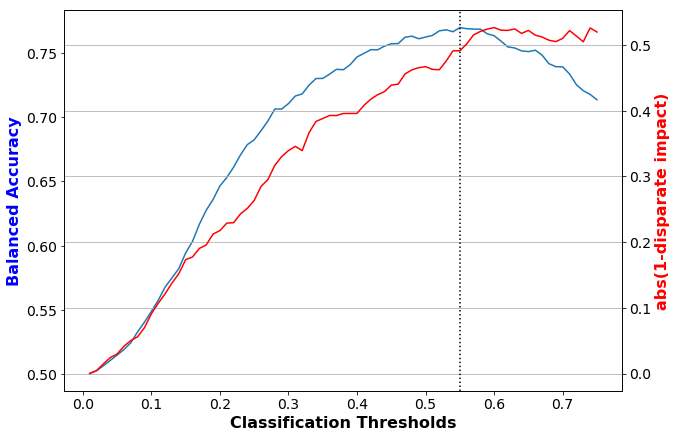

In [31]:
#Plot balanced accuracy, abs(1-disparate impact)

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(thresh_arr, bal_acc_arr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(thresh_arr, np.abs(1.0-np.array(disp_imp_arr)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')

ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)


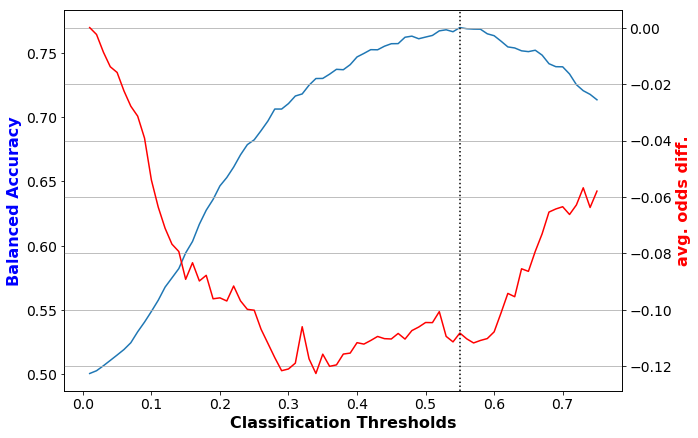

In [32]:
#Plot average odds difference
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(thresh_arr, bal_acc_arr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(thresh_arr, avg_odds_diff_arr, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')

ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [33]:
dir_thresh_arr_orig_meps_best = thresh_arr_best
print("Threshold corresponding to Best balanced accuracy: %6.4f" % dir_thresh_arr_orig_meps_best)
dir_best_bal_acc_arr_orig_meps = best_bal_acc
print("Best balanced accuracy: %6.4f" % dir_best_bal_acc_arr_orig_meps)
dir_disp_imp_at_best_bal_acc_orig_meps = disp_imp_at_best_bal_acc
print("Corresponding abs(1-disparate impact) value: %6.4f" % dir_disp_imp_at_best_bal_acc_orig_meps)
dir_avg_odds_diff_at_best_bal_acc_orig_meps = avg_odds_diff_at_best_bal_acc
print("Corresponding average odds difference value: %6.4f" % dir_avg_odds_diff_at_best_bal_acc_orig_meps)

dir_stat_par_diff_at_best_bal_acc_orig_meps = stat_par_diff_at_best_bal_acc
print("Corresponding statistical parity difference value: %6.4f" % dir_stat_par_diff_at_best_bal_acc_orig_meps)
dir_eq_opp_diff_at_best_bal_acc_orig_meps = eq_opp_diff_at_best_bal_acc
print("Corresponding equal opportunity difference value: %6.4f" % dir_eq_opp_diff_at_best_bal_acc_orig_meps)
dir_theil_ind_at_best_bal_acc_orig_meps = theil_ind_at_best_bal_acc
print("Corresponding Theil index value: %6.4f" % dir_theil_ind_at_best_bal_acc_orig_meps)

Threshold corresponding to Best balanced accuracy: 0.5500
Best balanced accuracy: 0.7696
Corresponding abs(1-disparate impact) value: 0.4911
Corresponding average odds difference value: -0.1083
Corresponding statistical parity difference value: -0.1881
Corresponding equal opportunity difference value: -0.0944
Corresponding Theil index value: 0.0916


<a id="di-test"></a>

#### 3.5.3. Testing DIR model

In [34]:
#Test model on given dataset and find threshold for best balanced accuracy
import numpy as np
from tqdm import tqdm
thresh_arr = np.linspace(0.01, 0.75, 75)

dataset = meps_orig_test        #data to test on
scale = meps_orig_dir_scale
model = meps_orig_dir

te_dataset= dataset.copy(deepcopy=True)
te_dataset.features = scale.transform(te_dataset.features)

di = DisparateImpactRemover(repair_level=1.0)

test_repd = di.fit_transform(te_dataset)  #repair test dataset

index = te_dataset.feature_names.index(sens_attr)        
X_te = np.delete(test_repd.features, index, axis=1)
    

y_te_pred_prob = model.predict_proba(X_te)

thresh_arr = dir_thresh_arr_orig_meps_best    

y_te_pred = (y_te_pred_prob[:,1] > thresh).astype(np.double)

test_repd_pred = test_repd.copy()
test_repd_pred.labels = y_te_pred

classified_metric = ClassificationMetric(test_repd, 
                                             test_repd_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
metric_pred = BinaryLabelDatasetMetric(test_repd_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
bal_acc = 0.5*(classified_metric.true_positive_rate() + classified_metric.true_negative_rate())
    
acc = accuracy_score(y_true=test_repd.labels,
                        y_pred=test_repd_pred.labels)

best_bal_acc = bal_acc
disp_imp_at_best_bal_acc = np.abs(1.0-metric_pred.disparate_impact())

avg_odds_diff_at_best_bal_acc = classified_metric.average_odds_difference()

stat_par_diff_at_best_bal_acc = classified_metric.statistical_parity_difference()
eq_opp_diff_at_best_bal_acc = classified_metric.equal_opportunity_difference()
theil_ind_at_best_bal_acc = classified_metric.theil_index()

In [35]:
dir_thresh_arr_orig_meps_best_test = thresh_arr_best
print("Threshold corresponding to Best balanced accuracy: %6.4f" % dir_thresh_arr_orig_meps_best_test)
dir_best_bal_acc_arr_orig_meps_best_test = best_bal_acc
print("Best balanced accuracy: %6.4f" % dir_best_bal_acc_arr_orig_meps_best_test)
dir_disp_imp_at_best_bal_acc_orig_meps_best_test = disp_imp_at_best_bal_acc
print("Corresponding abs(1-disparate impact) value: %6.4f" % dir_disp_imp_at_best_bal_acc_orig_meps_best_test)
dir_avg_odds_diff_at_best_bal_acc_orig_meps_best_test = avg_odds_diff_at_best_bal_acc
print("Corresponding average odds difference value: %6.4f" % dir_avg_odds_diff_at_best_bal_acc_orig_meps_best_test)

dir_stat_par_diff_at_best_bal_acc_orig_meps_best_test = stat_par_diff_at_best_bal_acc
print("Corresponding statistical parity difference value: %6.4f" % dir_stat_par_diff_at_best_bal_acc_orig_meps_best_test)
dir_eq_opp_diff_at_best_bal_acc_orig_meps_best_test = eq_opp_diff_at_best_bal_acc
print("Corresponding equal opportunity difference value: %6.4f" % dir_eq_opp_diff_at_best_bal_acc_orig_meps_best_test)
dir_theil_ind_at_best_bal_acc_orig_meps_best_test = theil_ind_at_best_bal_acc
print("Corresponding Theil index value: %6.4f" % dir_theil_ind_at_best_bal_acc_orig_meps_best_test)

Threshold corresponding to Best balanced accuracy: 0.5500
Best balanced accuracy: 0.7233
Corresponding abs(1-disparate impact) value: 0.5133
Corresponding average odds difference value: -0.0898
Corresponding statistical parity difference value: -0.1213
Corresponding equal opportunity difference value: -0.1282
Corresponding Theil index value: 0.1126


While disparate impact remover resulted in a model that is relatively fairer than, for examaple, the logistic regression model learnt from original data, it is quite unfair with an bs(1-disparate impact) value much higher than the typically desired value of < 0.2

<a id="summary-2015-learning"></a>

### 3.6. Summary of MEPS Model Learning Results

[Back to TOC](#toc)<br>

Logistic Regression classifier 'without' bias mitigation

In [36]:
print("Threshold corresponding to Best balanced accuracy: %6.4f" % lr_thresh_arr_orig_meps_best_test)
print("Best balanced accuracy: %6.4f" % lr_best_bal_acc_arr_orig_meps_best_test)
print("Corresponding abs(1-disparate impact) value: %6.4f" % lr_disp_imp_at_best_bal_acc_orig_meps_best_test)
print("Corresponding average odds difference value: %6.4f" % lr_avg_odds_diff_at_best_bal_acc_orig_meps_best_test)
print("Corresponding statistical parity difference value: %6.4f" % lr_stat_par_diff_at_best_bal_acc_orig_meps_best_test)
print("Corresponding equal opportunity difference value: %6.4f" % lr_eq_opp_diff_at_best_bal_acc_orig_meps_best_test)
print("Corresponding Theil index value: %6.4f" % lr_theil_ind_at_best_bal_acc_orig_meps_best_test)

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7759
Corresponding abs(1-disparate impact) value: 0.5738
Corresponding average odds difference value: -0.2057
Corresponding statistical parity difference value: -0.2612
Corresponding equal opportunity difference value: -0.2228
Corresponding Theil index value: 0.0921


Logistic Regression classifier using Pre-Processing Bias Mitigation - ReWeighing

In [37]:
print("Threshold corresponding to Best balanced accuracy: %6.4f" % lr_thresh_arr_transf_meps_best_test)
print("Best balanced accuracy: %6.4f" % lr_best_bal_acc_arr_transf_meps_best_test)
print("Corresponding abs(1-disparate impact) value: %6.4f" % lr_disp_imp_at_best_bal_acc_transf_meps_best_test)
print("Corresponding average odds difference value: %6.4f" % lr_avg_odds_diff_at_best_bal_acc_transf_meps_best_test)
print("Corresponding statistical parity difference value: %6.4f" % lr_stat_par_diff_at_best_bal_acc_transf_meps_best_test)
print("Corresponding equal opportunity difference value: %6.4f" % lr_eq_opp_diff_at_best_bal_acc_transf_meps_best_test)
print("Corresponding Theil index value: %6.4f" % lr_theil_ind_at_best_bal_acc_transf_meps_best_test)

Threshold corresponding to Best balanced accuracy: 0.2200
Best balanced accuracy: 0.7539
Corresponding abs(1-disparate impact) value: 0.2482
Corresponding average odds difference value: -0.0151
Corresponding statistical parity difference value: -0.0872
Corresponding equal opportunity difference value: -0.0035
Corresponding Theil index value: 0.0966


Model learnt using In-Processing Bias Mitigation - Prejudice Remover

In [38]:
print("Threshold corresponding to Best balanced accuracy: %6.4f" % pr_thresh_arr_orig_meps_best_test)
print("Best balanced accuracy: %6.4f" % pr_best_bal_acc_arr_orig_meps_best_test)
print("Corresponding abs(1-disparate impact) value: %6.4f" % pr_disp_imp_at_best_bal_acc_orig_meps_best_test)
print("Corresponding average odds difference value: %6.4f" % pr_avg_odds_diff_at_best_bal_acc_orig_meps_best_test)
print("Corresponding statistical parity difference value: %6.4f" % pr_stat_par_diff_at_best_bal_acc_orig_meps_best_test)
print("Corresponding equal opportunity difference value: %6.4f" % pr_eq_opp_diff_at_best_bal_acc_orig_meps_best_test)
print("Corresponding Theil index value: %6.4f" % pr_theil_ind_at_best_bal_acc_orig_meps_best_test)

Threshold corresponding to Best balanced accuracy: 0.1200
Best balanced accuracy: 0.6880
Corresponding abs(1-disparate impact) value: 0.1588
Corresponding average odds difference value: 0.0523
Corresponding statistical parity difference value: -0.0566
Corresponding equal opportunity difference value: 0.1479
Corresponding Theil index value: 0.1108


Model learnt using Pre-Processing Bias Mitigation - Disparate Impact Remover

In [39]:
print("Threshold corresponding to Best balanced accuracy: %6.4f" % dir_thresh_arr_orig_meps_best_test)
print("Best balanced accuracy: %6.4f" % dir_best_bal_acc_arr_orig_meps_best_test)
print("Corresponding abs(1-disparate impact) value: %6.4f" % dir_disp_imp_at_best_bal_acc_orig_meps_best_test)
print("Corresponding average odds difference value: %6.4f" % dir_avg_odds_diff_at_best_bal_acc_orig_meps_best_test)
print("Corresponding statistical parity difference value: %6.4f" % dir_stat_par_diff_at_best_bal_acc_orig_meps_best_test)
print("Corresponding equal opportunity difference value: %6.4f" % dir_eq_opp_diff_at_best_bal_acc_orig_meps_best_test)
print("Corresponding Theil index value: %6.4f" % dir_theil_ind_at_best_bal_acc_orig_meps_best_test)

Threshold corresponding to Best balanced accuracy: 0.5500
Best balanced accuracy: 0.7233
Corresponding abs(1-disparate impact) value: 0.5133
Corresponding average odds difference value: -0.0898
Corresponding statistical parity difference value: -0.1213
Corresponding equal opportunity difference value: -0.1282
Corresponding Theil index value: 0.1126


Of all the models, the logistic regression model after reweighing gives the best balance in terms of balanced accuracy and fairness. While the model learnt by prejudice remover is slightly fairer, it has much lower accuracy. 

<a id="deployment-2015-2015"></a>